In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

#these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {'FL': {}, 'RI': {}}
this_state = 'FL'

pop_total_denominator = 330759736
nDistricts = 435
target = pop_total_denominator / nDistricts


g = 0
scale = 20
map_buffer_ratio = .1
theproj = 3857 #{'init': 'epsg:9822'}
equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
desired_pct_area_overlap = 0.5

show_water = True
show_roads = False
water_area_tol = 1 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('state_name')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('state').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state_finder in these_states_dict.keys():
    these_states_dict[this_state_finder]['seats_old'] = state_seats_df[state_seats_df['stusab'] == this_state_finder]['seats_old'].values[0]
    these_states_dict[this_state_finder]['seats_new'] = state_seats_df[state_seats_df['stusab'] == this_state_finder]['seats_new'].values[0]
#pprint(these_states_dict)
#print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))


looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!
Got old and new numbers of districts for 2 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


In [8]:
# print('getting states...')
# state_all_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
# state_all_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_all_gdf['STATEFP'], errors='coerce')
# #state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
# #state_all_gdf[~state_all_gdf['STUSPS'].isin(['DC', 'PR', 'MP', 'VI', 'AS', 'GU'])][['STATEFP', 'STUSPS', 'NAME']].sort_values(by='STUSPS')
# state_all_gdf.columns


# Read redistricting geo data

In [9]:
s = time.time()
print('reading redistricting geography data for focus states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for focus states...
	reading flgeo2020.pl...
	reading rigeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 613,897 geographies in 0 minutes 24 seconds!


In [10]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state_finder in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state_finder]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state_finder))
    print('\t\t{0:} CRS = {1:}'.format(this_state_finder, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')

#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for FL...
		12 CRS = epsg:4269
	getting shapefiles for RI...
		44 CRS = epsg:4269


Joined 5,410 tracts to shapefiles in 12.7 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


adding shapefiles...


Joined 29 congressional districts to shapefiles in 2.4 seconds!


In [14]:
s = time.time()

# state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
# state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()
    #state_numbers_include_list = list(set([pandas.to_numeric(x[89:91], errors='coerce') for x in waterfiles]))
    #[x for x in waterfiles if ()]
    #possible_state_list = state_codes_df[state_codes_df['STATE'] <= 56]['STATE'].tolist()
    for i in range(0, len(waterfiles)):
#        print(state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
#        print(water_gdf.head(1).T)
#        break
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


getting states...
getting counties...
Got 56 states and 3,234 counties in 6.3 seconds!


getting water areas...
	reading water file 0 of 72...
	reading water file 10 of 72...
	reading water file 20 of 72...
	reading water file 30 of 72...
	reading water file 40 of 72...
	reading water file 50 of 72...
	reading water file 60 of 72...
	reading water file 70 of 72...
Got 1,268 water areas in 0 minutes 29.8 seconds!


getting CBSAs (metro areas)...
Got 939 CBSAs in 2.5 seconds!


getting places...
	reading place file 0 of 2...
Got 991 places in 1.0 seconds!


Done!


In [15]:
# s = time.time()
# print('finding Lake Okeechobee...')

# obc = [-81.15,26.6,-80.61,27.22]
# okeechobee_parts_gdf = geopandas.overlay(water_gdf.reset_index(), geopandas.GeoDataFrame(data=[[box(obc[0], obc[1], obc[2], obc[3])]], columns=['geometry'], crs=water_gdf.crs, geometry='geometry'), how='intersection')

# okeechobee_parts_gdf = okeechobee_parts_gdf[
#     (okeechobee_parts_gdf['FULLNAME'].isnull()) 
#     | 
#     (
#         (okeechobee_parts_gdf['FULLNAME'].dropna().apply(lambda x: 'riv' not in x.lower()))
#         & (okeechobee_parts_gdf['FULLNAME'].dropna().apply(lambda x: 'cnl' not in x.lower()))
#         & (okeechobee_parts_gdf['FULLNAME'].dropna().apply(lambda x: 'hicpochee' not in x.lower()))
#     )
# ].sort_values(by='AWATER', ascending=False).set_index('HYDROID')

# okeechobee_parts_gdf = okeechobee_parts_gdf.drop(['110455225440', '110453796056'], axis=0)

# okeechobee_gdf = geopandas.GeoDataFrame(data=[[unary_union(okeechobee_parts_gdf.geometry.tolist())]], columns=['geometry'], crs=water_gdf.crs, geometry='geometry')


# # fig, ax = plt.subplots(1,1, figsize=(8,8))
# # ax.set_aspect('equal')
# # okeechobee_parts_gdf.plot(ax=ax)
# # cnt = 0
# # for ix, thisrow in okeechobee_parts_gdf.iterrows():
# #     if (cnt in [10,12]):
# #         print(ix)
# #     annotator = '{0:}\n'.format(cnt, ix)
# #     centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
# #     ax.annotate(annotator, centerpoint, 
# #                 color='black', backgroundcolor='white', ha='center', va='center', 
# #                 fontsize=9)
# #     cnt += 1


# # #for i in range(1,)
# # #cd_gdf[cd_gdf['CD116'] == 1]

# # state_districts_average = cd_gdf['POP100'].sum() / len(cd_gdf)
# # state_target = state_districts_average
# # for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1):
# #     print('District {0:} (pop = {1:,.0f} ({2:.1%} of target, overshoot = {3:,.0f}))'.format(cd_gdf[cd_gdf['CD116'] == i]['BASENAME'].values[0], cd_gdf[cd_gdf['CD116'] == i]['POP100'].sum(), cd_gdf[cd_gdf['CD116'] == i]['POP100'].sum() / state_districts_average, cd_gdf[cd_gdf['CD116'] == i]['POP100'].sum() - state_districts_average))

# # print(okeechobee_parts_gdf.shape)#.sort_values(by='AWATER', ascending=False)


# #okeechobee_gdf.plot(ax=ax)
# e = time.time()
# g += (e-s)

# print('Got a single shape for Lake Okeechobee in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))


In [44]:
s = time.time()

print('setting up insets for {0:}...'.format(this_state))
insets = {}

insets['se'] = {}
insets['se']['how'] = 'districts'
insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
insets['se']['axes_position'] = [0.3, 0.01]
insets['se']['axes_rel_size'] = .255
insets['se']['districts'] = [21,22,23,24,27]
insets['se']['partial_districts'] = [18,20,25,26]
insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
insets['se']['title'] = 'Southeast Florida'
insets['se']['titlesize'] = 22
insets['se']['borderwidth'] = 3

insets['tpa'] = {}
insets['tpa']['how'] = 'districts'
#insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
insets['tpa']['axes_position'] = [0.03, 0.015]
insets['tpa']['axes_rel_size'] = 0.255
insets['tpa']['districts'] = [13,14]
insets['tpa']['partial_districts'] = [12, 15, 16]
insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
insets['tpa']['title'] = 'Tampa Bay'
insets['tpa']['titlesize'] = 22
insets['tpa']['borderwidth'] = 3

insets['orl'] = {}
insets['orl']['how'] = 'counties'
insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

insets['orl']['axes_position'] = [0.03, 0.26]
insets['orl']['axes_rel_size'] = 0.255
insets['orl']['districts'] = [7,10]
insets['orl']['partial_districts'] = [6,8,9,11,15]
insets['orl']['counties'] = ['Orange County', 'Seminole County']
insets['orl']['title'] = 'Orlando'
insets['orl']['titlesize'] = 22
insets['orl']['borderwidth'] = 3

insets['jax'] = {}
insets['jax']['how'] = 'counties'
insets['jax']['axes_position'] = [0.84, 0.87]
insets['jax']['axes_rel_size'] = 0.15
insets['jax']['districts'] = [4,5]
insets['jax']['partial_districts'] = [3]
insets['jax']['counties'] = ['Duval County']
insets['jax']['title'] = 'Jacksonville'
insets['jax']['titlesize'] = 22
insets['jax']['borderwidth'] = 3

insets['tally'] = {}
insets['tally']['how'] = 'places'
insets['tally']['axes_position'] = [0.84, 0.69]
insets['tally']['axes_rel_size'] = 0.15
insets['tally']['districts'] = [2,5]
insets['tally']['partial_districts'] = []
insets['tally']['counties'] = ['Leon County']
insets['tally']['places'] = ['Tallahassee']
insets['tally']['title'] = 'Tallahassee'
insets['tally']['titlesize'] = 22
insets['tally']['borderwidth'] = 3


for inset_name, inset in insets.items():
    print(inset_name)
    
    if ('bounds' in inset.keys()):
        inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
    else:
        if (inset['how'] == 'districts'):
            thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
        elif (inset['how'] == 'counties'):
            thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
        elif (inset['how'] == 'places'):
            thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
        xlims = [thegeo[0], thegeo[2]]
        ylims = [thegeo[1], thegeo[3]]        
        xspan = xlims[1] - xlims[0]
        yspan = ylims[1] - ylims[0]
        inset['aspect_ratio'] = xspan / yspan
        xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
        ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
        xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
        ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
        inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
        #print(inset['bounds'])
    
    inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
        box(
            inset['bounds'][0], 
            inset['bounds'][1], 
            inset['bounds'][2], 
            inset['bounds'][3]
        )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
    inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
#    print(inset['axes_size'])

all_inset_districts = []
for inset in insets.values():
    all_inset_districts += inset['districts']
    
main_map_districts = [x for x in list(range(1, these_states_dict[this_state]['seats_old']+1)) if x not in all_inset_districts]

main_map_districts += [x for x in insets['jax']['districts']]
main_map_districts += [x for x in insets['tally']['districts']]
main_map_districts = sorted(main_map_districts)

#print(main_map_districts)
e = time.time()
g += (e-s)
print('Done!')
#main_map_districts

setting up insets for FL...
se
tpa
orl
jax
tally
Done!


main map...
	plotting congressional districts...
		Plotting district 1...
		Plotting district 11...
		Plotting district 26...
	plotting census tracts...
	plotting water areas...
inset se...
	districts...
		Plotting District 21...
		Plotting District 22...
		Plotting District 23...
		Plotting District 24...
		Plotting District 27...
	partial districts...
		Plotting District 18...
		Plotting District 20...
		Plotting District 25...
		Plotting District 26...
	tracts...
	counties...
	water..
inset tpa...
	districts...
		Plotting District 13...
		Plotting District 14...
	partial districts...
		Plotting District 12...
		Plotting District 15...
		Plotting District 16...
	tracts...
	counties...
	water..
inset orl...
	districts...
		Plotting District 7...
		Plotting District 10...
	partial districts...
		Plotting District 6...
		Plotting District 8...
		Plotting District 9...
		Plotting District 11...
		Plotting District 15...
	tracts...
	counties...
	water..
inset jax...
	districts...
		Plotti

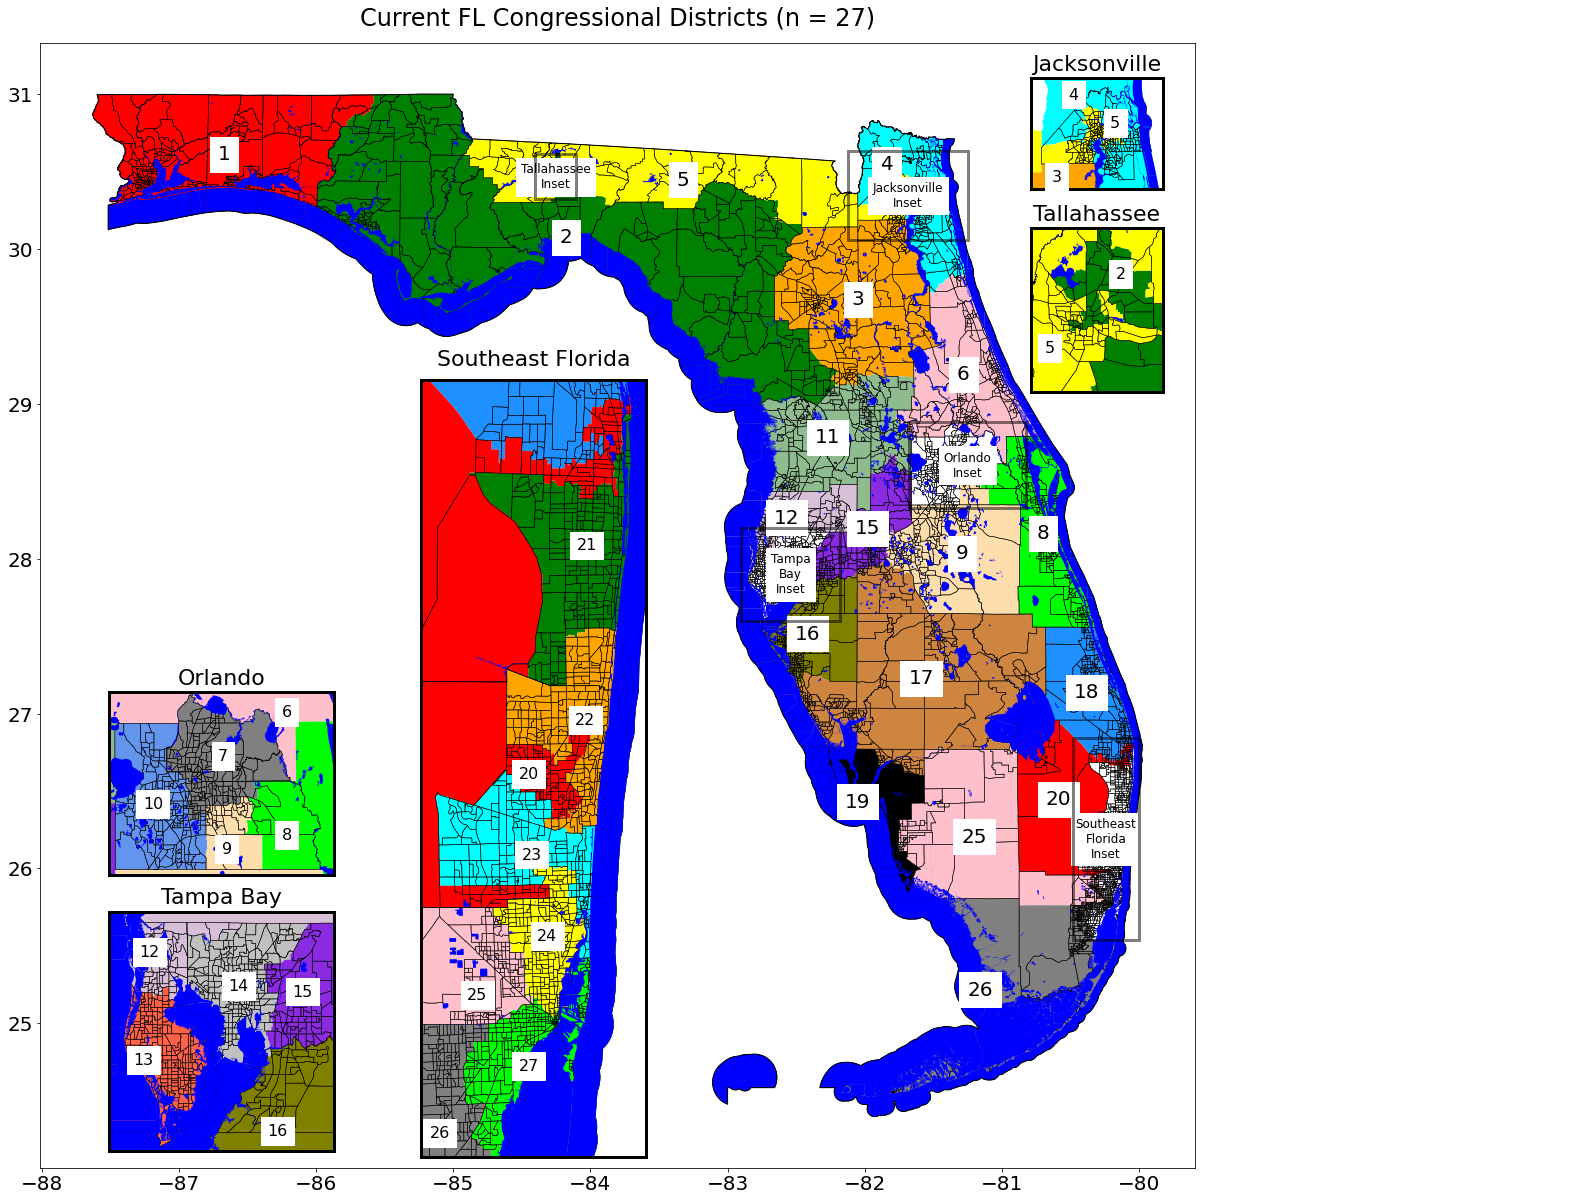

In [45]:
s = time.time()
#this_state = 'FL'
show_tracts = True
show_water = True

print('main map...')
print('\tplotting congressional districts...')
#print(state_gdf.head(1).T)

main_map_aspect_ratio = (unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[2] - unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[0]) / (unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[3] - unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[1])


fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')

#all_districts = list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1))

legend_list = []
for thiscd in main_map_districts:
    if ((np.mod(thiscd, 10) == 1) | (thiscd == max(main_map_districts))):
        print('\t\tPlotting district {0:.0f}...'.format(thiscd))
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)].plot(ax=ax, color=district_color_cycle[thiscd])
    legend_list.append(mpatches.Patch(color=district_color_cycle[thiscd], label='District {0:,.0f}'.format(thiscd)))
    annotator = thiscd
    centerpoint = (cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)]['INTPTLON'].values[0], cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)]['INTPTLAT'].values[0])
    ax.annotate(annotator, centerpoint, 
                color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting water areas...')
    water_gdf[water_gdf['STUSAB'] == this_state].plot(ax=ax, color='blue')

state_gdf[state_gdf['STUSPS'] == this_state].plot(ax=ax, color='none', edgecolor='black')


    
#ax.legend(handles=legend_list, fontsize=10, loc='lower right')

ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
    this_state, 
    these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
), fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)


for inset_name, inset in insets.items():
    print('inset {0:}...'.format(inset_name))
    inset['axes'] = ax.inset_axes([inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]])
    inset['axes'].set_aspect('equal')
    print('\tdistricts...')
    for thiscd in inset['districts']:
        print('\t\tPlotting District {0:.0f}...'.format(thiscd))
        cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)].plot(ax=inset['axes'], color=district_color_cycle[thiscd])
        annotator = thiscd 
        centerpoint = (cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
        inset['axes'].annotate(annotator, centerpoint, 
                    color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
    print('\tpartial districts...')
    for thiscd in inset['partial_districts']:
        print('\t\tPlotting District {0:.0f}...'.format(thiscd))
        cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)].plot(ax=inset['axes'], color=district_color_cycle[thiscd])
    if (show_tracts):
        print('\ttracts...')
        tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(inset['counties']))].plot(ax=inset['axes'], color='none', edgecolor='black', lw=0.5)
        print('\tcounties...')
        county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].apply(lambda x: x+' County' in inset['counties']))].plot(ax=inset['axes'], color='none', edgecolor='black', lw=inset['borderwidth']/8)
    
    if (show_water):
        print('\twater..')
        water_gdf[water_gdf['STUSAB'] == this_state].plot(ax=inset['axes'], color='blue')

    inset['axes'].set_xlim(inset['bounds'][0], inset['bounds'][2])
    inset['axes'].set_ylim(inset['bounds'][1], inset['bounds'][3])
    
    for this_side in ['top', 'bottom', 'left', 'right']:
        inset['axes'].spines[this_side].set_linewidth(inset['borderwidth'])
    inset['axes'].set_title(inset['title'], fontsize=inset['titlesize'], y=1.01)
    inset['axes'].set_xticks([])
    inset['axes'].set_yticks([])

    rectpatch, connects = ax.indicate_inset_zoom(inset['axes'], edgecolor="black", linewidth=inset['borderwidth'])
    citylabel = '{0:}\nInset'.format(inset['title'].replace(' ','\n'))
    citylabel_center = [rectpatch.get_x()+(rectpatch.get_width()/2), rectpatch.get_y()+(rectpatch.get_height()/2)]
    ax.annotate(citylabel, citylabel_center, color='black', backgroundcolor='white',  ha='center', va='center', fontsize=12)
    
    for j in range(0,4):
        connects[j].set_visible(False)

print('Adding some district labels by hand...')
insets['jax']['axes'].annotate(3, (-81.95,30.12), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['jax']['axes'].annotate(5, (-81.56,30.4), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)

insets['tally']['axes'].annotate(2, (-84.2, 30.53), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['tally']['axes'].annotate(5, (-84.36, 30.4), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)

insets['orl']['axes'].annotate(6, (-81, 28.82), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['orl']['axes'].annotate(8, (-81, 28.45), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['orl']['axes'].annotate(9, (-81.23, 28.41), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)

insets['tpa']['axes'].annotate(12, (-82.77, 28.1), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['tpa']['axes'].annotate(15, (-82.28, 28), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['tpa']['axes'].annotate(16, (-82.36, 27.65), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)

insets['se']['axes'].annotate(20, (-80.25, 26.18), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['se']['axes'].annotate(25, (-80.36, 25.81), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['se']['axes'].annotate(26, (-80.44, 25.58), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)



# print('saving figure...')
# fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
#[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]



In [81]:
state_target = cd_gdf['POP100'].sum() / these_states_dict[this_state]['seats_new']
print('{0:,.0f} districts, each with {1:,.0f} people!'.format(these_states_dict[this_state]['seats_new'], state_target))

28 districts, each with 808,413 people!


In [73]:
print('Finding CBSAs in {0:}...'.format(this_state))

# cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
# for ix, thisrow in cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'geometry']].sort_values(by='NAME').iterrows():
#     cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[tract_gdf.geometry.apply(lambda x: x.within(thisrow.geometry))]['POP100'].sum()
    
print('Found populations for {0:,.0f} CBSAs (total pop = {1:,.0f})!'.format(len(cbsa_gdf['POP100'].dropna()), cbsa_gdf['POP100'].sum()))

cbsa_gdf[['NAME', 'POP100']].sort_values(by='POP100', ascending=False)

Finding CBSAs in FL...
Found populations for 29 CBSAs (total pop = 21,185,186)!


,NAME,POP100
GEOID,,
33100,"Miami-Fort Lauderdale-Pompano Beach, FL",6138333.0
45300,"Tampa-St. Petersburg-Clearwater, FL",3175275.0
36740,"Orlando-Kissimmee-Sanford, FL",2673376.0
27260,"Jacksonville, FL",1605848.0
35840,"North Port-Sarasota-Bradenton, FL",833716.0
15980,"Cape Coral-Fort Myers, FL",760822.0
29460,"Lakeland-Winter Haven, FL",725046.0
19660,"Deltona-Daytona Beach-Ormond Beach, FL",668921.0
37340,"Palm Bay-Melbourne-Titusville, FL",606612.0


In [ ]:
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Miami-Dade County') & (tract_gdf['INTPTLON'] <= -80.45) , 'new_district'] = 28
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Miami-Dade County') & (tract_gdf['INTPTLAT'] <= 25.645) , 'new_district'] = 28


# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Palm Beach County') & ((tract_gdf['INTPTLON'] >= -80.30) & (tract_gdf['INTPTLON'] <= -80.17) & (tract_gdf['INTPTLAT'] <= 26.55)) , 'new_district'] = 22
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Palm Beach County') & ((tract_gdf['INTPTLON'] >= -80.17) & (tract_gdf['INTPTLAT'] <= 26.59)) , 'new_district'] = 22

# tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Walton County'])) & (tract_gdf['INTPTLAT'] >= 30.6) , 'new_district'] = 1
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Walton County'])) & (tract_gdf['INTPTLAT'] < 30.6) , 'new_district'] = 2

# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Duval County') & (tract_gdf['INTPTLON'] < -81.8) , 'new_district'] = 3
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Duval County') & (((tract_gdf['INTPTLON'] >= -81.8) & (tract_gdf['INTPTLON'] <= -81.55)) & ((tract_gdf['INTPTLAT'] >= 30.25))) , 'new_district'] = 4    # Central Jacksonville
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Clay County') & (tract_gdf['INTPTLON'] >= -81.85) , 'new_district'] = 5
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Duval County') & (tract_gdf['INTPTLAT'] <= 30.175) , 'new_district'] = 5
# tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Brevard County') & (tract_gdf['INTPTLAT'] >= 28.075) , 'new_district'] = 6


In [ ]:
#      ['Escambia County',1],
#      ['Santa Rosa County',1],
#      ['Okaloosa County',1],
#      ['Holmes County',1],
#      ['Washington County',2],
#      ['Bay County',2],
#      ['Gadsden County',2],
#      ['Calhoun County',2],
#      ['Gulf County',2],
#      ['Liberty County',2],    
#      ['Franklin County',2],   
#     ['Jackson County',2],   
#     ['Wakulla County',2],   
#     ['Leon County',2],   
#     ['Jefferson County',2],
#     ['Madison County',2],
#     ['Taylor County',2],
#     ['Hamilton County',3],
#     ['Suwannee County',3], 
#     ['Columbia County',3],
#     ['Baker County',3],
#     ['Lafayette County',3],
#     ['Gilchrist County',3],
#     ['Dixie County',3],
#     ['Levy County',3],
#     ['Alachua County',3],
#     ['Union County',3],
#     ['Bradford County',3],
#     ['Nassau County',3],
#      ['St. Johns County',5],
#     ['Volusia County',6],
#     ['Marion County',7],






#    ['Kendall',28],
#      ['Richmond Heights',28],
#      ['The Crossings',28],
#      ['The Hammocks',28],
#      ['Pinecrest',28], 

#    ['Miami',26],
#      ['Key Biscayne',26],
#      ['Miami Beach',26], 
#      ['North Bay Village',26],    
#      ['South Miami',26], 
#      ['Coral Gables',26], 
#      ['West Miami',26], 
#      ['Coral Terrace',26], 
#      ['Miami Shores',26],
#      ['North Miami',26],

#   ['Kendale Lakes',27],
#      ['Kendall West',27],
#      ['Sunset',27],
#      ['Glenvar Heights',27],
#      ['Westwood Lakes',27],
#      ['Olympia Heights',27],
#      ['Tamiami',27],
#      ['Westchester',27],
#      ['Fountainebleau',27],
#      ['Sweetwater',27],
#      ['Doral',27],
#      ['Virginia Gardens',27],
#      ['Miami Springs',27],
#      ['Hialeah',27],
#      ['Hialeah Gardens',27],
#      ['Brownsville',27],
#      ['Gladeview',27],
#      ['West Little River',27],
#      ['Pinewood',27],

    
#     ['Opa-locka',25], 
#     ['Miami Gardens',25],
#     ['Medley',25],
#     ['Westview',25],
#     ['Golden Glades',25], 
#     ['Miami Lakes',25],
#     ['Country Club',25],
#     ['Golden Beach',25],
#     ['Miramar',25],
#     ['Pembroke Pines',25],
#     ['Pembroke Park',25],
#     ['West Park',25],
#     ['Cooper City',25],
#     ['Southwest Ranches',25],
#     ['Weston',25],
#     ['Lauderdale Lakes',25],
    
    
    
#     ['Ives Estates',24],
#     ['North Miami Beach',24],
#    ['Ojus',24],    
#   ['Aventura',24],
#   ['Sunny Isles Beach',24],    
   
    
    
#     ['Hallandale Beach',24],    
    
#     ['Hollywood',24],
#     ['Dania Beach',24],
    
    
    
#     ['Fort Lauderdale',24],
#     ['Lazy Lake',24],
#     ['Oakland Park',24],
#     ['Wilton Manors',24],
#     ['Sea Ranch Lakes',24],
#     ['Lauderdale-by-the-Sea',24],
    


#      ['Pompano Beach',24],
#      ['Hillsboro Beach',24],

#      ['Lighthouse Point',24],



    
#     ['Broadview Park',23],
    
#     ['Davie',23],
#     ['Lauderdale Lakes',23],

#     ['Plantation',23],
#     ['Sunrise',23],
#     ['Lauderhill',23],
#     ['North Lauderdale',23],
#     ['Margate',23],
#     ['Coral Springs',23],
#     ['Coconut Creek',23],
#     ['Tamarac',23],
    
    

#     ['Deerfield Beach',22],
#    ['Parkland',22],
#    ['Watergate',22],
   
#    ['Hillsboro Pines',22],
    
#     ['Neptune Beach',5],
#     ['Jacksonville Beach',5],
#     ['Palm Coast',5],
#     ['Palatka',5],
#     ['DeBary',7],
#     ['Deltona',7],
#     ['Orange City',7],
#     ['DeLand',7],
#     ['Eustis',7],
#     ['Mount Dora',7],
#     ['Tavares',7],
#     ['Orlando',8],



# tract_gdf.loc[['1400000US12086006201', '1400000US12086007902'], 'new_district'] = 26  # Surrounded by but not in Miami City (south part of city)
# tract_gdf.loc[['1400000US12086007601', '1400000US12086007607', '1400000US12086007609'], 'new_district'] = 26  # Surrounded by but not in South Miami
# tract_gdf.loc[['1400000US12086004500', '1400000US12086004602', '1400000US12086980400'], 'new_district'] = 26  # Key Biscayne
# tract_gdf.loc[['1400000US12086003909', '1400000US12086003914', '1400000US12086003919', '1400000US12086003922', '1400000US12086004103', '1400000US12086004303'], 'new_district'] = 26  # Miami Beach
# tract_gdf.loc[['1400000US12086003801', '1400000US12086003803', '1400000US12086003804'], 'new_district'] = 26  # # Bal Harbor / Bay Harbor Islands / Indian Creek / Surfside
# tract_gdf.loc[['1400000US12086001101', '1400000US12086001207', '1400000US12086001208', '1400000US12086001209'], 'new_district'] = 26   # Biscayne Park


# tract_gdf.loc[['1400000US12086015001', '1400000US12086015002', '1400000US12086015101'], 'new_district'] = 27  # Far west of Miami
# tract_gdf.loc[['1400000US12086009040', '1400000US12086009066', '1400000US12086009101', '1400000US12086009102', '1400000US12086980500'], 'new_district'] = 27   # Between Virginia Gardens and South Miami
# tract_gdf.loc[['1400000US12086001704', '1400000US12086001705'], 'new_district'] = 27 # Between Miami and Virginia Gardens



# tract_gdf.loc[['1400000US12086012701'], 'new_district'] = 25 # Northern part of Hialeah Gardens, orginally 27
# tract_gdf.loc[['1400000US12086012403', '1400000US12086012501'], 'new_district'] = 25 # West of Country Club
# tract_gdf.loc[['1400000US12086012403', '1400000US12086012501'], 'new_district'] = 25 # West of Palm Springs North
# tract_gdf.loc[['1400000US12086000505', '1400000US12086980800'], 'new_district'] = 25 # Between Opa-locka and Miami Lakes
# tract_gdf.loc[['1400000US12086012200', '1400000US12086012301', '1400000US12086012302', '1400000US12086012401', '1400000US12086012402'], 'new_district'] = 25 # Palm SP
# tract_gdf.loc[['1400000US12086010013', '1400000US12086010015', '1400000US12086010016', '1400000US12086010017', '1400000US12086010018'], 'new_district'] = 25 # Between Miami Gardens and Country Club
# tract_gdf.loc[['1400000US12086000213', '1400000US12086000226'], 'new_district'] = 25  # Surrounded by North Miami Beach
# tract_gdf.loc[['1400000US12086012502'], 'new_district'] = 25  # North end of Hialeah
# tract_gdf.loc[['1400000US12011070306', '1400000US12011070310'], 'new_district'] = 25 # East of Weston


# tract_gdf.loc[['1400000US12086009601', '1400000US12086009602'], 'new_district'] = 24 # Between Miami Gardens and Ives Estates
# tract_gdf.loc[['1400000US12086000213', '1400000US12086000226'], 'new_district'] = 24 # Between Ives Estates and North Miami Beach
# tract_gdf.loc[['1400000US12086000130'], 'new_district'] = 24 # Isles Beach
# tract_gdf.loc[['1400000US12011080200'], 'new_district'] = 24  # Random tract in the middle of Fort Lauderdale
# tract_gdf.loc[['1400000US12011040505', '1400000US12011040506'], 'new_district'] = 24  # Weird coastal tracts in Fort Lauderdale
# tract_gdf.loc[['1400000US12086000115'], 'new_district'] = 24  # North of Golden Beach
# tract_gdf.loc[['1400000US12011041100'], 'new_district'] = 24   # Washington Park / Franklin Park / Roosevelt Gardens    
# tract_gdf.loc[['1400000US12011031203'], 'new_district'] = 24   # S of Hillsboro Beach


# tract_gdf.loc[['1400000US12011070304'], 'new_district'] = 23  # East of Weston
# tract_gdf.loc[['1400000US12011010601'], 'new_district'] = 23  # South edge of Parkland


# tract_gdf.loc[['1400000US12099007754', '1400000US12099007757', '1400000US12099007779'], 'new_district'] = 22  # SW of West Palm Beach
# tract_gdf.loc[['1400000US12099007710', '1400000US12099007770', '1400000US12099007771'], 'new_district'] = 22  # SW of West Palm Beach
# tract_gdf.loc[['1400000US12099004810', '1400000US12099004820', '1400000US12099004821', '1400000US12099004822', '1400000US12099004823'], 'new_district'] = 22  # West of Atlantis


# tract_gdf.loc[['1400000US12133970200'], 'new_district'] = 1  # NW Washington County



# tract_gdf.loc[['1400000US12031010301', '1400000US12031010501', '1400000US12031010502'], 'new_district'] = 3    # NNW Duval County

# tract_gdf.loc[['1400000US12019030103', '1400000US12019030104', '1400000US12019030105', '1400000US12019030106', '1400000US12019031101', '1400000US12019980000'], 'new_district'] = 3    # NW Clay County
# tract_gdf.loc[['1400000US12019030204', '1400000US12019030205'], 'new_district'] = 3    # NW Clay County

# tract_gdf.loc[['1400000US12019031104', '1400000US12019031105', '1400000US12019031108', '1400000US12019031109', '1400000US12019031110'], 'new_district'] = 3    # SW Clay County




# tract_gdf.loc[['1400000US12031010105', '1400000US12031010107', '1400000US12031014601'], 'new_district'] = 4  # NE Jacksonville
# tract_gdf.loc[['1400000US12031011901', '1400000US12031011903', '1400000US12031011905'], 'new_district'] = 4  # Central-west Jacksonville area
# tract_gdf.loc[['1400000US12031012702', '1400000US12031013728'], 'new_district'] = 4  # Central-west Jacksonville area
# tract_gdf.loc[['1400000US12031014603', '1400000US12031014604', '1400000US12031014328', '1400000US12031014329', '1400000US12031014330', '1400000US12031014333', '1400000US12031014334', '1400000US12031014335', '1400000US12031014336'], 'new_district'] = 4  # Jaxport area, just inland along river
# tract_gdf.loc[['1400000US12031013800', '1400000US12031013901', '1400000US12031013902', '1400000US12031013904', '1400000US12031013905', '1400000US12031013906'], 'new_district'] = 4  # Mouth of St. Johns River
# tract_gdf.loc[['1400000US12031013100', '1400000US12031013200', '1400000US12031013301', '1400000US12031013302', '1400000US12031013402', '1400000US12031013502', '1400000US12031013504'], 'new_district'] = 4  # SW Jax
# tract_gdf.loc[['1400000US12031013522', '1400000US12031013523', '1400000US12031013524', '1400000US12031013525', '1400000US12031013526', '1400000US12031013729', '1400000US12031013730', '1400000US12031013731'], 'new_district'] = 4  # SW Jax
# tract_gdf.loc[['1400000US12031016500', '1400000US12031016603', '1400000US12031016604', '1400000US12031016605'], 'new_district'] = 4  # South-central Jax
# tract_gdf.loc[['1400000US12031016711', '1400000US12031016724', '1400000US12031016725', '1400000US12031016726', '1400000US12031016727', '1400000US12031016728', '1400000US12031016729', '1400000US12031016730', '1400000US12031016731'], 'new_district'] = 4  # South-central Jax
# tract_gdf.loc[['1400000US12031015926'], 'new_district'] = 4  # South-central Jax
# tract_gdf.loc[['1400000US12031014414', '1400000US12031014428', '1400000US12031014311', '1400000US12031014343', '1400000US12031014344', '1400000US12031014312', '1400000US12031014338'], 'new_district'] = 4  # SE downtown Jax
# tract_gdf.loc[['1400000US12031014415', '1400000US12031014416', '1400000US12031014419', '1400000US12031014420'], 'new_district'] = 4  # SE downtown Jax
# tract_gdf.loc[['1400000US12031014339', '1400000US12031014340'], 'new_district'] = 4  # SE downtown Jax




# tract_gdf.loc[['1400000US12031014423', '1400000US12031016801'], 'new_district'] = 5  # SE Jax
# tract_gdf.loc[['1400000US12031014331', '1400000US12031014341', '1400000US12031014342', '1400000US12031014408', '1400000US12031014417', '1400000US12031014418'], 'new_district'] = 5  # SE Jax
# tract_gdf.loc[['1400000US12031014421', '1400000US12031014422', '1400000US12031014424', '1400000US12031014425', '1400000US12031014426'], 'new_district'] = 5  # SE Jax
# tract_gdf.loc[['1400000US12031015922', '1400000US12031015925'], 'new_district'] = 5  # SE Jax
# tract_gdf.loc[['1400000US12035060206'], 'new_district'] = 5 # NW Flagler county
# tract_gdf.loc[['1400000US12035060104', '1400000US12035060106', '1400000US12035060303'], 'new_district'] = 5 # Palm Coast
# tract_gdf.loc[['1400000US12035060218', '1400000US12035060302', '1400000US12035060304'], 'new_district'] = 5 # S of Palm Coast
# tract_gdf.loc[['1400000US12107950100', '1400000US12107950600', '1400000US12107950700', '1400000US12107950900', '1400000US12107951000'], 'new_district'] = 5 # Palatka
# tract_gdf.loc[['1400000US12107951100', '1400000US12107951200'], 'new_district'] = 5 # NE Putnam County
# tract_gdf.loc[['1400000US12107951300', '1400000US12107951401', '1400000US12107951402'], 'new_district'] = 5 # Far SE Putnam County
# tract_gdf.loc[['1400000US12035060207'], 'new_district'] = 5 # SW Flagler county



# tract_gdf.loc[['1400000US12127082411', '1400000US12127083207'], 'new_district'] = 6 # central Volusia County
# tract_gdf.loc[['1400000US12127091005', '1400000US12117021201', '1400000US12117021205', '1400000US12117021206'], 'new_district'] = 6   # Far east Seminole, far SW Volusia
# tract_gdf.loc[['1400000US12095016603', '1400000US12095016604', '1400000US12095016607'], 'new_district'] = 6   # Far east Orange




# tract_gdf.loc[['1400000US12069030102', '1400000US12069030104'], 'new_district'] = 7 # far north Lake County
# tract_gdf.loc[['1400000US12107950201', '1400000US12107950202', '1400000US12107950300', '1400000US12107950400', '1400000US12107950500', '1400000US12107980000'], 'new_district'] = 7    # Remainder of Putnam County
# tract_gdf.loc[['1400000US12127090202', '1400000US12127090304', '1400000US12127090305', '1400000US12127090307', '1400000US12127090701', '1400000US12127090702'], 'new_district'] = 7 # immediate vicinity of DeLand
# tract_gdf.loc[['1400000US12127090803', '1400000US12127090804', '1400000US12127091001', '1400000US12127091020', '1400000US12127091021'], 'new_district'] = 7 # immediate vicinity of DeLand
# tract_gdf.loc[['1400000US12127090203', '1400000US12127090204', '1400000US12127090303', '1400000US12127091029', '1400000US12127091035'], 'new_district'] = 7 # rest of Volusia county near Deland
# tract_gdf.loc[['1400000US12069030106', '1400000US12069030108', '1400000US12069030109', '1400000US12069030110', '1400000US12069030111', '1400000US12069030112'], 'new_district'] = 7 # north Lake County, west of DeLand
# tract_gdf.loc[['1400000US12117020707', '1400000US12069030203', '1400000US12069030916', '1400000US12069030917', '1400000US12069030918'], 'new_district'] = 7 # NW Seminole / NE Lake
# tract_gdf.loc[['1400000US12069030209', '1400000US12069030211', '1400000US12069030807', '1400000US12069030915'], 'new_district'] = 7 # NW Seminole / NE Lake
# tract_gdf.loc[['1400000US12069030302', '1400000US12069030305', '1400000US12069030306', '1400000US12069030307'], 'new_district'] = 7 # NW Seminole / NE Lake
# tract_gdf.loc[['1400000US12069030308', '1400000US12069030410', '1400000US12069030411', '1400000US12069030406'], 'new_district'] = 7 # NW Seminole / NE Lake


#tract_gdf.loc[tract_gdf['new_district'] == 4, 'new_district'] = np.nan


In [96]:
s = time.time()
doit = True
print('TARGET: {0:,.0f}'.format(state_target))
#print('\n')
#state_target = cd_gdf['POP100'].sum() / these_states_dict[list(these_states_dict.keys())[0]]['seats_new']

tract_gdf.loc[:, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[
#     ['Monroe County',28],

], columns=['COUNTY_NAME', 'new_district_by_county'])

place_mapper_df = pandas.DataFrame(data=[
    ['Miami', 26],

     ['Key Biscayne',26],
     ['Miami Beach',26], 
     ['North Bay Village',26],    
     ['South Miami',26], 
     ['Coral Gables',26], 
     ['West Miami',26], 
     ['Coral Terrace',26], 
     ['Miami Shores',26],
     ['North Miami',26],
     ['Golden Glades', 26],
     ['Pinewood', 26],
#      ['Westview', 26],
#     ['West Little River', 26],
#      ['Gladeview', 26],
#      ['Brownsville', 26],
    
    
    
#     ['Florida City', 28],
#     ['Homestead', 28],
#     ['Homestead Base', 28],    
#     ['Leisure City', 28],        
#     ['Naranja', 28],            
#     ['Princeton', 28],            
], columns=['NAME', 'new_district_by_place'])

print('Assigning districts by county...')
tract_gdf.loc[:, 'new_district'] = tract_df.reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']

# print('Assigning districts by lat/lon...')



print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))

for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    tracts_here = []
    tracts_within = tract_gdf[
                (tract_gdf['new_district'].isnull()) & 
                (tract_gdf.geometry.within(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
            ].index.tolist()
    
    tracts_here += tracts_within
    if (len(tracts_within) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
    
    tracts_intersect = tract_gdf[
                (tract_gdf['new_district'].isnull()) & 
                (tract_gdf.geometry.intersects(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
                & ~(tract_gdf.index.isin(tracts_within))
            ].index.tolist()
    if (len(tracts_intersect) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersect)))
        #print('\n')
        
        if (doit):
            cnt = 0
            for ix, thisrow in tract_gdf[tract_gdf.index.isin(tracts_intersect)].iterrows():
                cnt += 1
                if (np.mod(cnt, 10) == 0):
                    print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersect)))
                this_tract_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(epsg=equal_area_crs).geometry.area.values[0]
                intersection_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(
                    epsg=equal_area_crs).geometry.intersection(
                                    unary_union(
                            place_mapper_gdf[
                                place_mapper_gdf['new_district_by_place'] == i
                            ].to_crs(epsg=equal_area_crs).geometry.tolist())
                        ).to_crs(epsg=equal_area_crs).geometry.area.values[0]
                intersection_pct = intersection_area / this_tract_area



                #tract_gdf.to_crs(epsg=equal_area_crs).loc[ix].geometry.area
                if (intersection_pct >= desired_pct_area_overlap):
                    tracts_here.append(ix)
                    #print('Tract {0:}: {1:,.0f} m^2, intersection area {2:,.0f} m^2 ({3:.0%})'.format(ix, this_tract_area, intersection_area, intersection_pct))
                #break

            print('\t\tAssigning {0:.0f} place-matching tracts in District {1:.0f}!'.format(len(tracts_here), i))
            print('\n')
            tract_gdf.loc[tracts_here, 'new_district'] = i

        tract_gdf.loc[(tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist()))), 'new_district'] = i


print('Assigning districts by tract number...')

tract_gdf.loc[['1400000US12086006201', '1400000US12086007902'], 'new_district'] = 26  # Surrounded by but not in Miami City (south part of city)
tract_gdf.loc[['1400000US12086007601', '1400000US12086007607', '1400000US12086007609'], 'new_district'] = 26  # Surrounded by but not in South Miami
tract_gdf.loc[['1400000US12086004500', '1400000US12086004602', '1400000US12086980400'], 'new_district'] = 26  # Key Biscayne
tract_gdf.loc[['1400000US12086003909', '1400000US12086003914', '1400000US12086003919', '1400000US12086003922', '1400000US12086004103', '1400000US12086004303'], 'new_district'] = 26  # Miami Beach
tract_gdf.loc[['1400000US12086003801', '1400000US12086003803', '1400000US12086003804'], 'new_district'] = 26  # # Bal Harbor / Bay Harbor Islands / Indian Creek / Surfside
tract_gdf.loc[['1400000US12086001101', '1400000US12086001207', '1400000US12086001208', '1400000US12086001209'], 'new_district'] = 26   # Biscayne Park
tract_gdf.loc[['1400000US12086001103'], 'new_district'] = 26 # El Portal

# tract_gdf.loc[['1400000US12086011408', '1400000US12086011409', '1400000US12086011410', '1400000US12086011411', '1400000US12086011412', '1400000US12086011500'], 'new_district'] = 28  # Very rural Dade County
# tract_gdf.loc[['1400000US12086980100', '1400000US12086981200'], 'new_district'] = 28  # Key Largo in Dade County

# tract_gdf.loc[['1400000US12086019402', '1400000US12086980200'], 'new_district'] = 28  # Country Walk / Three Lakes
# tract_gdf.loc[['1400000US12086016501'], 'new_district'] = 28  # West of Kendall West
# tract_gdf.loc[['1400000US12086015202', '1400000US12086015300'], 'new_district'] = 28   # N of Kendall West
# tract_gdf.loc[['1400000US12086014100', '1400000US12086981100'], 'new_district'] = 28  # Far west of Miami

e = time.time()
g += (e-s)


print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
        total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))
print('\n')
#print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))


TARGET: 808,413
Assigning districts by county...
Assigning districts by place...
	Finding tracts that intersect places in District 26...
		Tracts within union of places: 182...
		Tracts that intersect union of places: 86...
			Examining tract 10 of 86...
			Examining tract 20 of 86...
			Examining tract 30 of 86...
			Examining tract 40 of 86...
			Examining tract 50 of 86...
			Examining tract 60 of 86...
			Examining tract 70 of 86...
			Examining tract 80 of 86...
		Assigning 213 place-matching tracts in District 26!


Assigning districts by tract number...
Assigned districts to 235 tracts in 0 minutes 51 seconds!


District 26: n = 812,966 (100.6% of target; overshot = 4,553)




xspan = 0.40 degrees
aspect_ratio  = 0.73:1


plotting tracts...


plotting state and county borders...


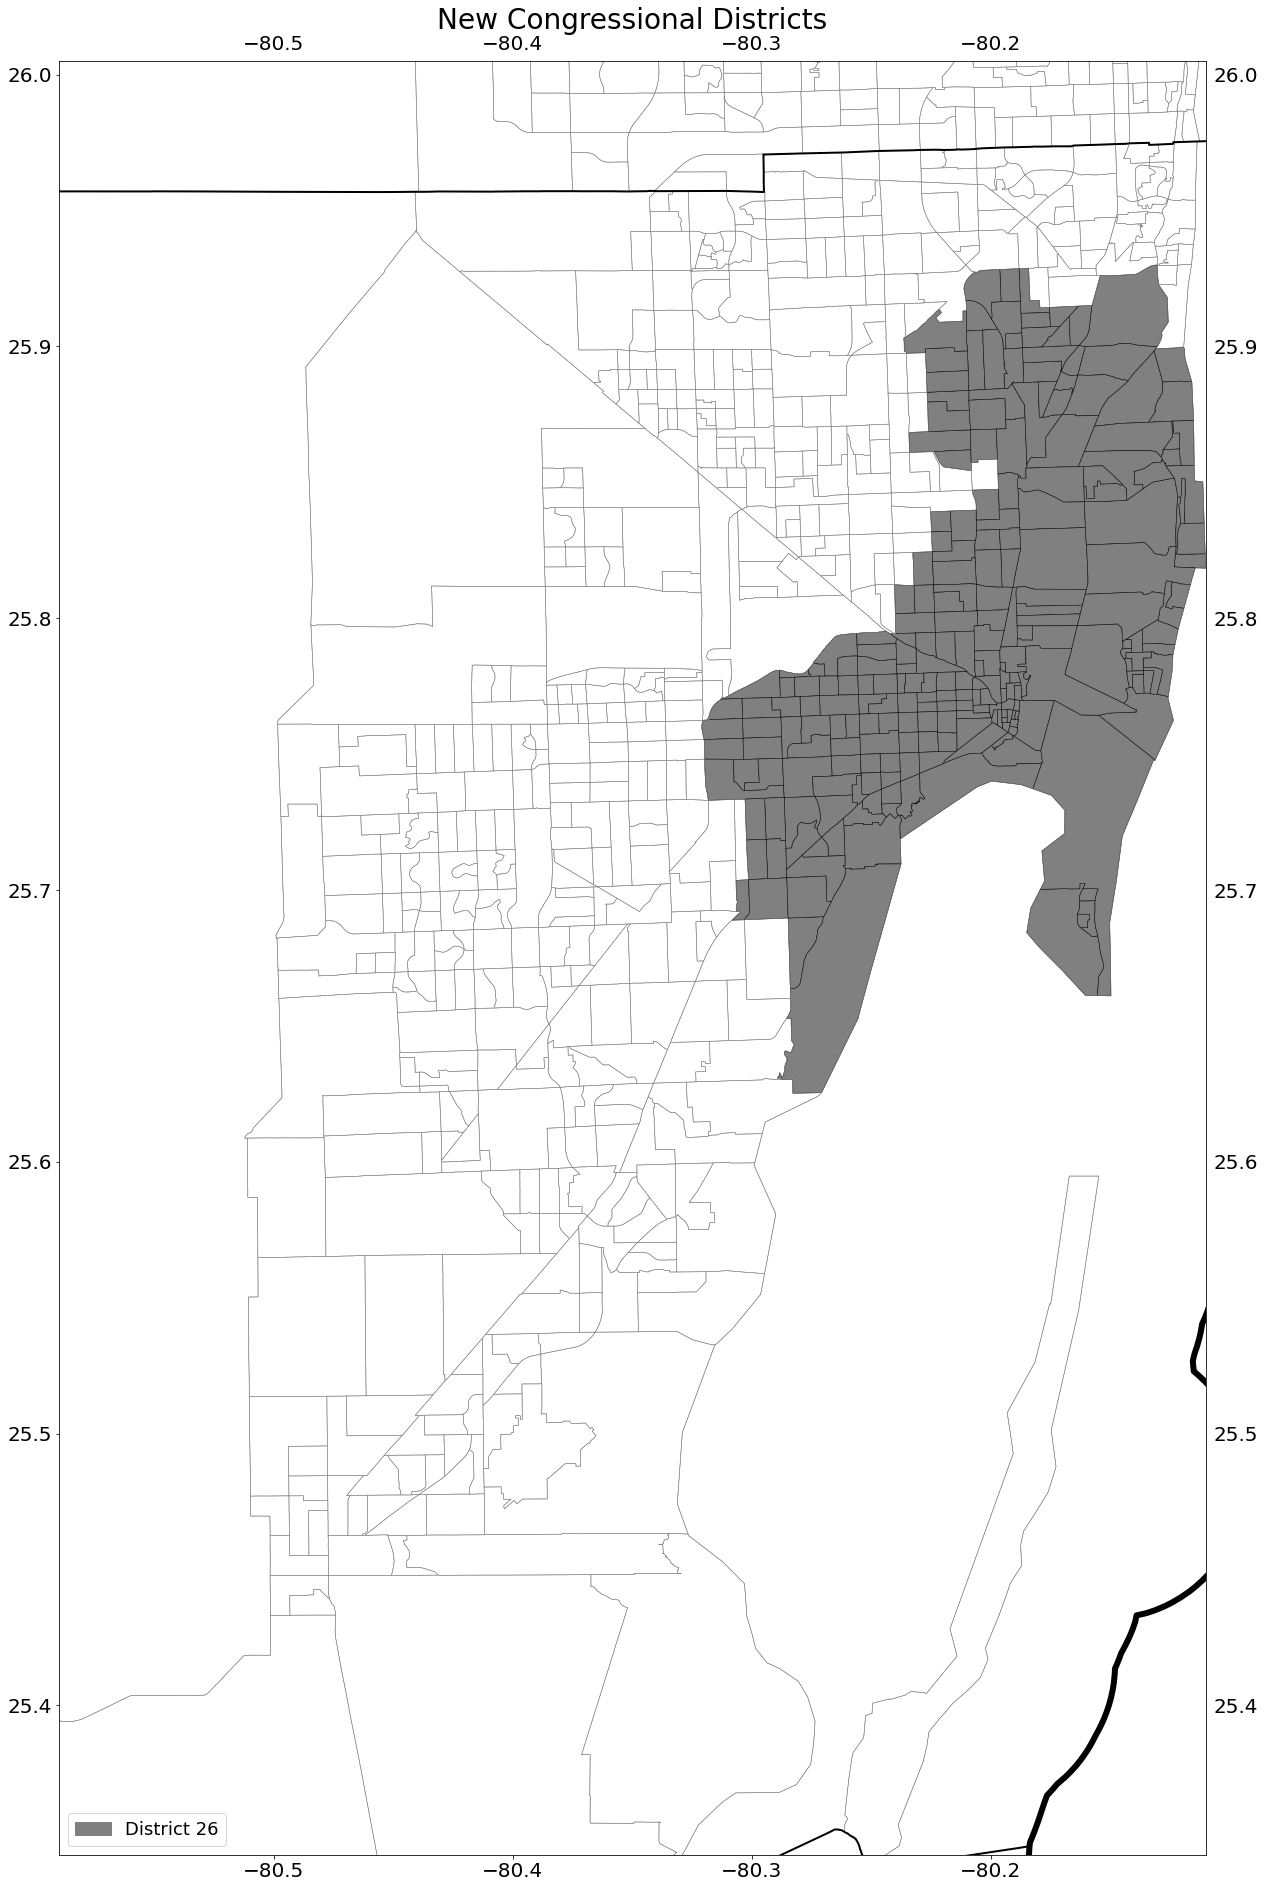



District 26: n = 812,966 (100.6% of target; overshot = 4,553)


In [99]:
show_water = False
show_roads = False
show_small_roads = False
label_tracts = False

show_places = False
label_places = False

show_counties = True
label_counties = False

the_label_size = 20
the_annotation_size = 16
the_line_width = .5
the_line_width_wide = 6
the_legend_size = 18
the_title_size = 28

bounds_counties = ['Miami-Dade']

if (len(bounds_counties) > 0):
    xlimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[0], unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[2]]
    ylimits = [unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[1], unary_union(county_gdf[county_gdf['NAME'].isin(bounds_counties)].geometry.tolist()).bounds[3]]
else:
    xlimits = [unary_union(state_gdf.geometry.tolist()).bounds[0], unary_union(state_gdf.geometry.tolist()).bounds[2]]
    ylimits = [unary_union(state_gdf.geometry.tolist()).bounds[1], unary_union(state_gdf.geometry.tolist()).bounds[3]]

    
# # # Populated Dade County
xlimits = [-80.55, -80.15]
ylimits = [25.4,25.95]

# SW of Miami City
# xlimits = [-80.45,-80.25]
# ylimits = [25.62,25.8]

# Tamiami / Kendall West
# xlimits = [-80.54,-80.425]
# ylimits = [25.68, 25.77]

### Miami / Miami Beach
# xlimits = [-80.35,-80.1]
# ylimits = [25.65,25.95]

# North of Miami
# xlimits = [-80.25,-80.1]
# ylimits = [25.85,25.95]

# NW of Miami
# xlimits = [-80.375,-80.175]
# ylimits = [25.75,25.95]

# NNW of Miami
# xlimits = [-80.395,-80.125]
# ylimits = [25.85,25.98]


# Remainder of Dade County (for District 24)
# xlimits = [-80.35,-80.165]
# ylimits = [25.85, 26]


    
xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xbuffer = xspan * map_buffer_ratio
ybuffer = yspan * map_buffer_ratio

xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

print('xspan = {0:,.2f} degrees'.format(xspan))
print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
print('\n')

# fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
ax.set_aspect('equal')

# print('plotting CBSAs...')
# cbsa_gdf[
#     ((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1]))
#     & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))
# ].plot(ax=ax, color='none', edgecolor='yellow')


print('plotting tracts...')

# base layer
legend_list = []
for i in range(-1,these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
        tract_gdf[(tract_gdf['new_district'] == i)].plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)        
        legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

tract_gdf[(tract_gdf['new_district'].isnull())].plot(ax=ax, color='none', edgecolor='gray', lw=the_line_width)


if (label_tracts):
    print('labeling tracts...')
    for ix, thisrow in tract_gdf[
        (((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1])) & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1])))
        & (tract_gdf['new_district'].isnull())
#        & (tract_gdf['new_district'] == 6)
#        & (tract_gdf['INTPTLAT'] >= 28.9)
#             & (
#                 ((tract_gdf['INTPTLAT'] >= 39.37) & (tract_gdf['new_district'] == 2))
#                 | ((tract_gdf['INTPTLON'] <=  -76.64) & (tract_gdf['new_district'] == 1))
#               )
    ].sort_values(by=['COUNTY_NAME', 'census_tract']).iterrows():
        print('{0:}-{1:}:\t{2:}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], ix))
        #print('{0:}:\t{1:}'.format(thisrow['census_tract'], ix))
        annotator = '{0:}-{1:}\n{2:,.0f}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], geo_df.loc[ix]['POP100'])
        #annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
        centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
        ax.annotate(annotator, centerpoint, 
                    color='gray', backgroundcolor='white', ha='center', va='center', 
                    fontsize=the_annotation_size)

if (show_places):
    print('plotting places...')
    place_gdf[
        ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
        & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
    ].plot(ax=ax, edgecolor='red', lw=the_line_width_wide, color='none')

if (label_places):
    print('\tlabeing all places on map...')
    for ix, thisrow in place_gdf[
        ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
        & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
    ].iterrows():
        #if (not(thisrow['NAME'] in ['Watergate', 'Hillsboro Pines', 'Roosevelt Gardens', 'Washington Park', 'Franklin Park', 'Boulevard Gardens'])):
        annotator = '{0:}\n{1:,.0f}'.format(thisrow['NAME'].replace('-','-\n').replace(' ','\n').upper(), geo_df.loc[ix]['POP100'])
        centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
        ax.annotate(annotator, centerpoint, 
                    color='red', backgroundcolor='white', ha='center', va='center', 
                    fontsize=the_annotation_size)

if (show_water):
    print('plotting water areas...')
    water_gdf.plot(ax=ax, color='blue')

    
if (show_roads):
    print('plotting roads...')
    if (show_small_roads):
        print('\tsmall...')
        roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color='black', linewidth=0.1)
    print('\tlarge...')
    roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=0.25) 
    roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=0.5) 
    roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=0.75)     
    roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=1) 

if (show_counties):
    print('\n')
    print('plotting state and county borders...')
    if (len(bounds_counties) > 0):   
        county_gdf[county_gdf['NAME'].isin(bounds_counties)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)
    else:
        county_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
    state_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
if (label_counties):
    print('labeling counties...')
    for ix, thisrow in county_gdf[(((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1])) & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1])))].iterrows():
        ax.annotate('{0:}'.format(thisrow['NAME']), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='gray', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)

plt.xlim(xlimits)
plt.ylim(ylimits)

#ax.set_xticks(np.arange(xlimits[0], xlimits[1], xspan/10))#, fontsize=the_label_size)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size)

#ax.set_yticks(np.arange(27.8, 28.8, 0.025))
ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size)

ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')

if (len(list(these_states_dict.keys())) == 1):
    plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
    ), fontsize=the_title_size)
else:    
    plt.title('New Congressional Districts', fontsize=the_title_size)



plt.show()
print('\n')
for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))


In [ ]:

# for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))



In [ ]:
# new_district_shapes_gdf = geopandas.GeoDataFrame(data=None, columns=['new_district', 'geometry'], crs=tract_gdf.crs, geometry='geometry').set_index('new_district')
# for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     print('merging tract shapes get district {0:,.0f} boundaries...'.format(i))
#     new_district_shapes_gdf.loc[i, 'geometry'] = unary_union(tract_gdf[tract_gdf['new_district'] == i].geometry.tolist())    
# #new_district_shapes_gdf = new_district_shapes_gdf.reset_index()
    
# xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]

# fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# ax.set_aspect('equal')
# #thedistricts = [x for x in cd_gdf['CD116'].drop_duplicates().tolist()]

# thedistricts = list(set([int(x) for x in cd_gdf['CD116'].drop_duplicates().tolist()]))

# legend_list = []

# print('ploting congressional districts...')
# for thiscd in thedistricts:
#     print('Plotting district {0:.0f}...'.format(thiscd))
#     new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
#     #cd_gdf[cd_gdf['CD116'] == thiscd].to_crs(epsg=theproj).plot(ax=ax, color=district_color_cycle[thiscd])
#     #cd_gdf[cd_gdf['CD116'] == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
#     legend_list.append(mpatches.Patch(color=district_color_cycle[thiscd], label='District {0:,.0f}'.format(thiscd)))
    
    
#     annotator = thiscd #parse_road_name(thisrow['FULLNAME'])
#     centerpoint = (unary_union(new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].geometry.tolist()).centroid.x, unary_union(new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].geometry.tolist()).centroid.y)
#     #centerpoint = (new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
#     ax.annotate(annotator, centerpoint, 
#                 color='black', backgroundcolor='white', ha='center', va='center', fontsize=2.25*scale)
    
# print('ploting census tracts...')
# tract_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.0625*scale)

# if (show_water):
#     print('ploting water areas...')
#     water_gdf.plot(ax=ax, color='blue')
    
# #state_gdf.to_crs(epsg=theproj).plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
# state_gdf.plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
    
# ax.legend(handles=legend_list, fontsize=2.25*scale)

# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
#     ), fontsize=3*scale)
# else:
#     plt.title('Current Congressional Districts', fontsize=3*scale)

# plt.xticks(fontsize=2*scale)
# plt.yticks(fontsize=2*scale)

# plt.show()

# # #fig.get_size_inches()
# #cd_gdf[cd_gdf['CD116'] == 'ZZ']




In [ ]:
################## MIAMI-DADE COUNTY #########################
# # # Populated Dade County
# xlimits = [-80.55, -80.15]
# ylimits = [25.4,25.95]

# SW of Miami City
# xlimits = [-80.45,-80.25]
# ylimits = [25.62,25.8]

# Tamiami / Kendall West
# xlimits = [-80.54,-80.425]
# ylimits = [25.68, 25.77]

# Miami / Miami Beach
# xlimits = [-80.35,-80.1]
# ylimits = [25.65,25.95]

# North of Miami
# xlimits = [-80.25,-80.1]
# ylimits = [25.85,25.95]

# NW of Miami
# xlimits = [-80.375,-80.175]
# ylimits = [25.75,25.95]

# NNW of Miami
# xlimits = [-80.395,-80.125]
# ylimits = [25.85,25.98]


# Remainder of Dade County (for District 24)
# xlimits = [-80.35,-80.165]
# ylimits = [25.85, 26]


################## BROWARD COUNTY #########################
# # # Populated Broward County
# xlimits = [-80.45,-80]
# ylimits = [25.9,26.35]

# South coast of Broward County / North coast of Dade County
# xlimits = [-80.215,-80.1]
# ylimits = [25.9,26.025]

# Fort Lauderdale
# xlimits = [-80.25,-80.05]
# ylimits = [25.95,26.25]

# Fort Lauderdale / Pompano Beach
# xlimits = [-80.3,-80]
# ylimits = [25.95,26.35]

# North of Pompano Beach
# xlimits = [-80.3,-80]
# ylimits = [26.25,26.34]

#  Washington Park / Franklin Park / Roosevelt Gardens / Boulevard Gardens
# xlimits = [-80.21,-80.17]
# ylimits = [26.12,26.15]


################## PALM BEACH COUNTY #########################
# # # South end of Palm Beach County
# xlimits = [-80.3,-80]
# ylimits = [26.3,26.6]


# # # North end of Palm Beach County
# xlimits = [-80.4,-80]
# ylimits = [26.6,27]

# # # West Palm Beach
# xlimits = [-80.3,-80]
# ylimits = [26.56,26.82]

# # # West of Atlantis
# xlimits = [-80.2, -80.12]
# ylimits = [26.59, 26.63]



################## PANHANDLE #########################

# WESTERN PANHANDLE
# xlimits = [-88,-83]
# ylimits = [29,31]

# EASTERN PANHANDLE TO JACKSONVILLE
# xlimits = [-84,-81]
# ylimits = [29,30.7]


################## JACKSONVILLE #########################

## WESTERN EDGE OF JACKSONVILLE
# xlimits = [-82.1,-81.7]
# ylimits = [29.4,30.8]
        
# ## DOWNTOWN JACKSONVILLE 
# xlimits = [-81.9,-81.45]
# ylimits = [30.15,30.55]
    
# ## Port Jax
# xlimits = [-81.6,-81.35]
# ylimits = [30.3,30.4]

## SE Jax
# xlimits = [-81.7,-81.4]
# ylimits = [30.1,30.35]

# ## SE Downtown Jax
# xlimits = [-81.56,-81.35]
# ylimits = [30.2,30.325]



################ CENTRAL FLORIDA #########################
# DELAND AREA AND NE SEMINOLE
# xlimits = [-81.6,-81.1]
# ylimits = [28.8,29.2]

# # DELAND
# # xlimits = [-81.4,-81.2]
# # ylimits = [28.93,29.08]

# # LAKE / SEMINOLE
# xlimits = [-81.95,-81.65]
# ylimits = [28.75,28.95]
